# 1. Install dependencies

In [ ]:
# Install libraries we will be using in this notebook
!pip install -q --upgrade openai praw matplotlib tqdm rake-nltk wordcloud spacy nltk
!pip install -q "pandas==2.2.2" "numpy<2.3" "tenacity<9"

# Download a small English spaCy model. We will use this for entity extraction
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 97.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 2. Imports

In [ ]:
# Basic Imports
import os, json, math, time, textwrap
import json
from getpass import getpass
from typing import List, Dict, Tuple
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from tenacity import retry, wait_exponential, stop_after_attempt

import praw
from praw.models import MoreComments

from openai import OpenAI

import nltk
from rake_nltk import Rake
from wordcloud import WordCloud
import spacy
import re

# NLTK resources for RAKE
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)

# Jupyter matplotlib behavior
%matplotlib inline

# 3. Add your API Keys

In [ ]:
# 🔐 API Keys Loader (env → Colab Secrets → prompt)

# Get your Reddit API key here: https://www.reddit.com/prefs/apps/
# Get your OpenAI API key here: https://platform.openai.com/settings/

# Just run this block to add your keys.
# If you have added your keys to Google Colab, it will use those keys.
# If you haven't, then after running this block, Colab will ask you for your API keys interactively.

# Try to use Colab's Secrets helper; if not in Colab this import will fail (that's fine).
try:
    from google.colab import userdata  # type: ignore
except Exception:
    userdata = None

def _coerce_to_str_or_none(v):
    """Return a trimmed string if v looks like a string/bytes, else None."""
    if v is None:
        return None
    if isinstance(v, str):
        s = v.strip()
        return s if s else None
    if isinstance(v, (bytes, bytearray)):
        try:
            s = v.decode("utf-8").strip()
            return s if s else None
        except Exception:
            return None
    # If Colab ever returns an unexpected type (e.g., dict), ignore it and fall back.
    return None

def _colab_secret_or_none(name: str):
    """Fetch a Colab secret; return None if missing or inaccessible."""
    if userdata is None:
        return None
    try:
        raw = userdata.get(name)
    except Exception:
        return None
    return _coerce_to_str_or_none(raw)

def get_secret(name: str, *, prompt: str = None, default: str = None, mask: bool = True) -> str:
    """
    Priority:
      1) os.environ[name]         (string only)
      2) google.colab.userdata    (string/bytes only)
      3) default (if provided)
      4) prompt (getpass for secrets; input for non-secrets)
    Always stores the chosen value back into os.environ.
    """
    # 1) env
    v = _coerce_to_str_or_none(os.getenv(name))
    if v is not None:
        return v

    # 2) Colab Secrets
    v = _colab_secret_or_none(name)
    if v is not None:
        os.environ[name] = v
        return v

    # 3) default
    if default is not None:
        os.environ[name] = default
        return default

    # 4) prompt
    if mask:
        v = getpass(prompt or f"Enter {name}: ")
    else:
        v = input((prompt or f"Enter {name}: ")).strip()
    os.environ[name] = v
    return v

# --- Collect the API Keys we need ---
REDDIT_CLIENT_ID     = get_secret("REDDIT_CLIENT_ID",     prompt="Enter your Reddit client_id: ",     mask=True)
REDDIT_CLIENT_SECRET = get_secret("REDDIT_CLIENT_SECRET", prompt="Enter your Reddit client_secret: ", mask=True)
OPENAI_API_KEY       = get_secret("OPENAI_API_KEY",       prompt="Enter your OpenAI API key: ",       mask=True)

# User agent isn't sensitive → ideally show your own Reddit users that is associated with your Reddit API keys
DEFAULT_UA = "subreddit-analysis-notebook/0.1 by u/yourusername"
REDDIT_USER_AGENT    = get_secret(
    "REDDIT_USER_AGENT",
    prompt="Enter your Reddit user agent (e.g., 'subreddit-analysis-notebook/0.1 by u/yourusername'): ",
    default=DEFAULT_UA,
    mask=False
)

# --- Initialize clients ---
import praw
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY  # also lets the SDK auto-pick it up

reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT
)
oai = OpenAI(api_key=OPENAI_API_KEY)

print("✅ Secrets loaded. Reddit and OpenAI clients are ready.")

✅ Secrets loaded. Reddit and OpenAI clients are ready.


# 4. Configuration

In [ ]:
# --------------------
# User-configurable settings
# --------------------

# Reddit
SUBREDDIT           = os.getenv("SUBREDDIT", "SEO")    # change as desired
NUM_THREADS         = int(os.getenv("NUM_THREADS", 5))   # number of threads to fetch
NUM_COMMENTS_TOTAL  = int(os.getenv("NUM_COMMENTS", 15))  # number of comments to fetch  across the fetched threads
LISTING             = os.getenv("LISTING", "hot")         # type of "hot" | "new" | "top"

# OpenAI
# Model
OPENAI_MODEL        = os.getenv("OPENAI_MODEL", "gpt-5-mini") # "gpt-5", or "gpt-5-mini", "gpt-5-nano", "gpt-4o", etc.. GPT-5 models may need to verify your account in OpenAI
# Reasoning level
REASONING_LEVEL     = os.getenv("REASONING_LEVEL", "low").strip().lower() # minimal|low|medium|high

# Topics Configuration
# Topic definitions
TOPICS = [
    {
        "name": "Link Building",
        "description": "Acquiring relevant, high-quality backlinks from external sites via outreach, digital PR, content promotion, or partnerships. Includes anchor text, link quality/equity, rel=\"nofollow\"/\"sponsored\", disavow, and avoiding link schemes; excludes internal linking."
    },
    {
        "name": "Technical SEO",
        "description": "Site infrastructure and discoverability: crawling, indexation, rendering (incl. JavaScript), site speed/Core Web Vitals, mobile-friendliness, canonicalization, redirects, robots.txt, sitemaps, structured data, hreflang, and server responses. Not about content strategy or off-site links."
    },
    {
        "name": "Local SEO",
        "description": "Improving visibility in local/map results: Google Business Profile optimization (categories, hours, photos), NAP consistency, reviews, local citations/directories, location or service-area pages, and proximity signals."
    },
    {
        "name": "Tools",
        "description": "Discussions of SEO platforms/utilities used to audit/crawl sites, track rankings, analyze keywords/backlinks, or report performance (e.g., Search Console, site crawlers, rank trackers, keyword tools). Includes setup, comparisons, configurations, and interpreting outputs."
    },
    {
        "name": "Keyword Research",
        "description": "Finding and prioritizing search queries by volume, difficulty, and intent; expanding seed keywords; competitor/content-gap analysis; mapping keywords to pages and SERP features."
    },
    {
        "name": "On-page SEO",
        "description": "Optimizing on-site content and HTML elements to align with search intent: titles/title links, meta descriptions, headings, body copy, internal links, URLs, image alt text, and schema markup/E-E-A-T signals. Excludes external link acquisition."
    },
    {
        "name": "AI and SEO",
        "description": "Use and impact of generative AI on SEO workflows (ideation, drafting, optimization, clustering) and changes in search such as AI Overviews. Must align with Google guidance—AI content should be helpful and policy-compliant, not for manipulating rankings."
    }
]
# Number of threads/comments to show as examples for each topic
number_of_examples_topics = int(os.getenv("NUMBER_OF_EXAMPLES_TOPICS", 1))
# 🔧 Change this to the topic you want to analyze in the multi-dimensional slice (step #13)
TOPIC_OF_INTEREST = "Tools"


# Sentiment
# Number of threads/comments to show as examples for each sentiment
number_of_examples_sentiment = int(os.getenv("NUMBER_OF_EXAMPLES_SENTIMENT", 3))

# Keyword Extraction
keywords_to_extract = int(os.getenv("KEYWORDS_TO_EXTRACT", 50))
keyword_max_length_of_words = 3 # cap phrases to 3 words for better packing / visualization in the word cloud
keyword_min_length_of_words = 1 # allow single word keywords

# 5. Helper functions for calling to the OpenAI API

In [ ]:
# This block contains helper functions to call OpenAI API

# Token budgets to use when reasoning is enabled on GPT-5.
# We take max(requested_max_output_tokens, REASONING_TOKENS[level]).
REASONING_TOKENS = {
    "minimal": 300,
    "low":     1000,
    "medium":  5000,
    "high":   10000,
}

# Enforce JSON-only outputs when supported by the model (automatically falls back if not)
USE_JSON_MODE       = True

def _is_gpt5_model(name: str) -> bool:
    if not name: return False
    norm = re.sub(r"[\s_]+", "-", name.strip().lower())
    return norm.startswith("gpt-5")

def _map_reasoning_effort(level: str) -> str | None:
    if not level: return None
    level = level.strip().lower()
    if level in {"off", "none", "false", "0"}:
        return None
    if level in {"minimal", "low", "medium", "high"}:
        return level
    return "low"

def _responses_create_json(
    input_text: str,
    instructions: str,
    *,
    temperature: float | None = 0,
    max_output_tokens: int = 200,
) -> str:
    """
    Calls the OpenAI Responses API.
    - JSON mode when possible (auto-fallback if the SDK rejects it)
    - GPT-5 detection with optional reasoning
    - Drops/renames unsupported kwargs based on SDK error messages
    Returns: response.output_text (string)
    """
    model = OPENAI_MODEL
    is_gpt5 = _is_gpt5_model(model)

    # Build base payload
    kwargs = dict(model=model, input=input_text, instructions=instructions)

    # JSON mode (we'll remove it if the SDK doesn't support the kwarg)
    if USE_JSON_MODE:
        kwargs["response_format"] = {"type": "json_object"}

    # Reasoning (GPT-5 only). Also avoid sending temperature to GPT-5.
    eff_level = _map_reasoning_effort(REASONING_LEVEL) if is_gpt5 else None
    effective_max_tokens = int(max_output_tokens)

    if is_gpt5:
        if eff_level:
            boost = int(REASONING_TOKENS.get(eff_level, REASONING_TOKENS["low"]))
            effective_max_tokens = max(effective_max_tokens, boost)
            kwargs["reasoning"] = {"effort": eff_level}
        # Many GPT-5 variants reject temperature → don't send it
    else:
        if temperature is not None:
            kwargs["temperature"] = float(temperature)

    kwargs["max_output_tokens"] = effective_max_tokens

    # Try the call, removing unsupported kwargs if the SDK complains
    attempt = 0
    while True:
        attempt += 1
        try:
            resp = oai.responses.create(**kwargs)
            return resp.output_text
        except Exception as e:
            err = str(e)
            lower = err.lower()
            changed = False

            # SDK-level TypeError (method signature): “unexpected keyword argument 'X'”
            m = re.search(r"unexpected keyword argument '([^']+)'", err)
            if m:
                bad = m.group(1)
                if bad in kwargs:
                    kwargs.pop(bad, None); changed = True

            # API-level errors (400) that mention unsupported params
            if not changed and ("unsupported" in lower or "not supported" in lower):
                for bad in ("response_format", "temperature", "reasoning", "max_output_tokens"):
                    if bad in lower and bad in kwargs:
                        kwargs.pop(bad, None); changed = True
                # Some older SDKs/APIs expect max_tokens instead of max_output_tokens
                if "max_output_tokens" in lower and "max_output_tokens" in kwargs:
                    val = kwargs.pop("max_output_tokens")
                    kwargs["max_tokens"] = val
                    changed = True

            # Last-chance rename if error explicitly mentions max_output_tokens
            if not changed and "max_output_tokens" in lower and "max_output_tokens" in kwargs:
                val = kwargs.pop("max_output_tokens")
                kwargs["max_tokens"] = val
                changed = True

            if changed and attempt < 4:
                continue
            raise

def _safe_json_parse(txt: str) -> dict:
    try:
        return json.loads(txt)
    except Exception:
        start = txt.find("{"); end = txt.rfind("}")
        if start != -1 and end != -1 and end > start:
            return json.loads(txt[start:end+1])
        raise ValueError("Could not parse JSON from model output:\n" + txt)

# 6. Fetch threads and comments from the subreddit

In [ ]:
def _submission_iter(sub, listing: str, limit: int):
    if listing == "new":
        return sub.new(limit=limit)
    elif listing == "top":
        return sub.top(limit=limit)
    else:
        return sub.hot(limit=limit)

# Limit long texts passed to the model (in characters); classification doesn't need huge context
MAX_CHARS_PER_ITEM  = int(os.getenv("MAX_CHARS_PER_ITEM", 4000))

def fetch_reddit_data(subreddit: str, num_threads: int, num_comments_total: int, listing: str = "hot") -> pd.DataFrame:
    sub = reddit.subreddit(subreddit)

    # 1) Threads
    submissions = list(_submission_iter(sub, listing, num_threads))
    records = []
    for s in submissions:
        text = " ".join([t for t in [s.title or "", s.selftext or ""] if t]).strip()
        records.append({
            "type": "thread",
            "id": s.id,
            "parent_id": None,
            "link_id": s.id,
            "subreddit": str(s.subreddit),
            "author": str(getattr(s, "author", None)) if getattr(s, "author", None) else None,
            "score": int(getattr(s, "score", 0)),
            "created_utc": pd.to_datetime(getattr(s, "created_utc", None), unit="s", utc=True) if getattr(s, "created_utc", None) else None,
            "title": s.title or "",
            "body": s.selftext or "",
            "permalink": f"https://www.reddit.com{s.permalink}" if getattr(s, "permalink", None) else None,
            "url": getattr(s, "url", None),
            "text": text[:MAX_CHARS_PER_ITEM]
        })

    # 2) Up to N comments across those threads
    grabbed = 0
    for s in submissions:
        if grabbed >= num_comments_total:
            break
        s.comments.replace_more(limit=0)
        for c in s.comments.list():
            if grabbed >= num_comments_total:
                break
            if isinstance(c, MoreComments):
                continue
            body = (c.body or "").strip()
            if body.lower() in {"[deleted]", "[removed]"} or not body:
                continue
            records.append({
                "type": "comment",
                "id": c.id,
                "parent_id": c.parent_id,
                "link_id": c.link_id.replace("t3_", "") if hasattr(c, "link_id") else s.id,
                "subreddit": str(s.subreddit),
                "author": str(getattr(c, "author", None)) if getattr(c, "author", None) else None,
                "score": int(getattr(c, "score", 0)),
                "created_utc": pd.to_datetime(getattr(c, "created_utc", None), unit="s", utc=True) if getattr(c, "created_utc", None) else None,
                "title": "",
                "body": body,
                "permalink": f"https://www.reddit.com{c.permalink}" if getattr(c, "permalink", None) else None,
                "url": None,
                "text": body[:MAX_CHARS_PER_ITEM]
            })
            grabbed += 1

    df = pd.DataFrame.from_records(records)
    return df

df = fetch_reddit_data(SUBREDDIT, NUM_THREADS, NUM_COMMENTS_TOTAL, LISTING)
print(f"Fetched {len(df[df.type=='thread'])} threads and {len(df[df.type=='comment'])} comments from r/{SUBREDDIT} ({LISTING}).")
df.head(3)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Fetched 5 threads and 15 comments from r/SEO (hot).


,type,id,parent_id,link_id,subreddit,author,score,created_utc,title,body,permalink,url,text
0,thread,1ohwb8q,None,1ohwb8q,SEO,WebLinkr,22,2025-10-28 01:09:47+00:00,NEW! Query groups in Search Console Insights,"Monday, October 27, 2025\n\nWe are excited to ...",https://www.reddit.com/r/SEO/comments/1ohwb8q/...,https://developers.google.com/search/blog/2025...,NEW! Query groups in Search Console Insights M...
1,thread,1ojvqdx,None,1ojvqdx,SEO,Fine--5676,10,2025-10-30 10:10:38+00:00,Under Massive Negative SEO Attack - 100+ Domai...,My money keywords are tanking after a coordina...,https://www.reddit.com/r/SEO/comments/1ojvqdx/...,https://www.reddit.com/r/SEO/comments/1ojvqdx/...,Under Massive Negative SEO Attack - 100+ Domai...
2,thread,1ojvqo6,None,1ojvqo6,SEO,ilikearequipe,3,2025-10-30 10:11:07+00:00,Would you create local pages to rank for even ...,I'm an SEO newb and am building a site for a s...,https://www.reddit.com/r/SEO/comments/1ojvqo6/...,https://www.reddit.com/r/SEO/comments/1ojvqo6/...,Would you create local pages to rank for even ...


# 7. Sentiment classification (Positive / Neutral / Negative / Mixed)

In [ ]:
SENTIMENT_INSTRUCTIONS = (
    "You are a meticulous Reddit sentiment rater. "
    "Always respond with a SINGLE JSON object and nothing else."
)

def build_sentiment_prompt(text: str) -> str:
    return textwrap.dedent(f"""
    Task: Classify the sentiment of the Reddit text into EXACTLY one of:
    ["Positive", "Neutral", "Negative", "Mixed"].

    Output JSON ONLY with this schema:
    {{
      "sentiment": "Positive|Neutral|Negative|Mixed",
      "confidence": 0.0_to_1.0
    }}

    Text:
    \"\"\"{text.strip()}\"
    \"\"\"
    """)

@retry(wait=wait_exponential(min=1, max=30), stop=stop_after_attempt(5))
def classify_sentiment(text: str) -> Tuple[str, float]:
    if not text or not text.strip():
        return ("Neutral", 0.5)
    raw = _responses_create_json(
        input_text=build_sentiment_prompt(text[:MAX_CHARS_PER_ITEM]),
        instructions=SENTIMENT_INSTRUCTIONS,
        temperature=0,
        max_output_tokens=100
    )
    data = _safe_json_parse(raw)
    sent = data.get("sentiment", "Neutral")
    conf = float(data.get("confidence", 0.5))
    return (sent, conf)

# Apply to all rows
sentiments = []
confs = []
for t in tqdm(df["text"].tolist(), desc="Classifying sentiment"):
    s, c = classify_sentiment(t)
    sentiments.append(s)
    confs.append(c)

df["sentiment"] = sentiments
df["sentiment_confidence"] = confs


Classifying sentiment:   0%|          | 0/20 [00:00<?, ?it/s]

# 8. Sentiment Distribution & Examples

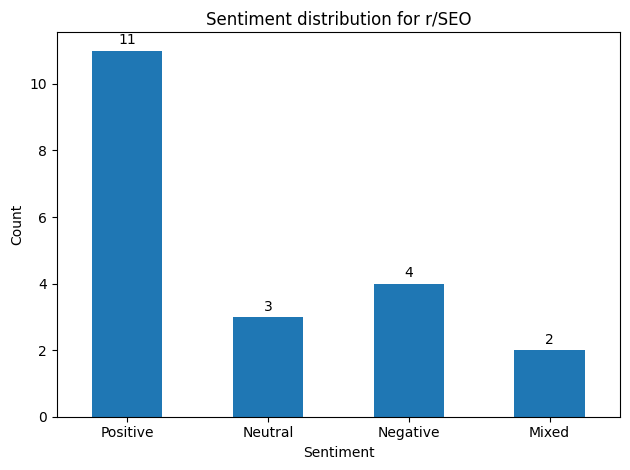


=== Positive (top 3 examples) ===
1. [comment] score=1 conf=0.95
   Oh nice - win!!!
   ↗ https://www.reddit.com/r/SEO/comments/1ohwb8q/new_query_groups_in_search_console_insights/nlva4ox/
2. [comment] score=3 conf=0.95
   Great analysis u/Ivan_Palii \- thanks for taking the time to deep dive into it...
   ↗ https://www.reddit.com/r/SEO/comments/1ohwb8q/new_query_groups_in_search_console_insights/nlva9g1/
3. [comment] score=3 conf=0.95
   Thanks for sharing
   ↗ https://www.reddit.com/r/SEO/comments/1ohwb8q/new_query_groups_in_search_console_insights/nlrx11u/

=== Neutral (top 3 examples) ===
1. [thread] score=3 conf=0.92
   Would you create local pages to rank for even if a service is mainly online? I'm an SEO newb and am building a site for a service provider who is mainly online. My q is, if they're mainly online, would it help them if I build local pages f…
   ↗ https://www.reddit.com/r/SEO/comments/1ojvqo6/would_you_create_local_pages_to_rank_for_even_if/
2. [comment] score=2 con

In [ ]:
# Let's plot sentiment distribution + print examples

def plot_sentiment_distribution(frame: pd.DataFrame, title: str = "Sentiment distribution"):
    order = ["Positive", "Neutral", "Negative", "Mixed"]
    counts = frame["sentiment"].value_counts().reindex(order, fill_value=0)
    ax = counts.plot(kind="bar", rot=0)
    ax.set_title(title)
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Count")
    for i, v in enumerate(counts.values):
        ax.text(i, v + 0.1, str(v), ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

def print_examples_by_sentiment(frame: pd.DataFrame, n: int = 3, max_chars: int = 240):
    """
    After plotting, print up to n examples per sentiment.
    Picks examples with highest sentiment_confidence (or score if confidence is missing).
    """
    order = ["Positive", "Neutral", "Negative", "Mixed"]
    for label in order:
        subset = frame[frame["sentiment"] == label].copy()
        if subset.empty:
            print(f"\n=== {label}: no examples ===")
            continue

        sort_col = "sentiment_confidence" if "sentiment_confidence" in subset.columns else "score"
        subset = subset.sort_values(sort_col, ascending=False)

        print(f"\n=== {label} (top {min(n, len(subset))} examples) ===")
        for i, (_, row) in enumerate(subset.head(n).iterrows(), 1):
            txt = (row.get("text") or "").strip()
            # collapse whitespace and truncate for readability
            txt = " ".join(txt.split())
            if len(txt) > max_chars:
                txt = txt[: max_chars - 1] + "…"

            link = row.get("permalink") or row.get("url") or ""
            origin = "thread" if row.get("type") == "thread" else "comment"
            conf = row.get("sentiment_confidence", None)
            conf_str = f"{conf:.2f}" if isinstance(conf, (float, int)) else "—"
            score = row.get("score", "NA")

            print(f"{i}. [{origin}] score={score} conf={conf_str}")
            print(f"   {txt}")
            if link:
                print(f"   ↗ {link}")

# Run the chart + examples
plot_sentiment_distribution(df, f"Sentiment distribution for r/{SUBREDDIT}")
print_examples_by_sentiment(df, n=number_of_examples_sentiment)

# 9. Topic Classification

In [ ]:
# Topics are configurable in a previous block (step #3 configuration)

TOPIC_INSTRUCTIONS_HEADER = (
    "You are an expert Reddit topic classifier. "
    "Return a SINGLE JSON object only, with keys 'labels', 'top_topic', and 'confidence'."
)

def build_topic_prompt(text: str, topics: List[Dict[str, str]]) -> str:
    catalog = {t["name"]: t["description"] for t in topics}
    topic_names = list(catalog.keys())
    return textwrap.dedent(f"""
    Task: Assign zero or more relevant topics to the Reddit text from the allowed set below.
    Also select 'top_topic' as the single best-fitting topic.

    Allowed topics (name -> description):
    {json.dumps(catalog, indent=2)}

    If nothing fits, use "Other" as both the only label and the top_topic.

    Output JSON ONLY with this schema:
    {{
      "labels": ["TopicName", ...],     // zero or more from {topic_names + ['Other']}
      "top_topic": "TopicName",         // single best label (or "Other")
      "confidence": {{
         "TopicName": 0.0_to_1.0,       // per-label confidence for every item in 'labels'
         "...": 0.0_to_1.0
      }}
    }}

    Text:
    \"\"\"{text.strip()}\"
    \"\"\"
    """)

@retry(wait=wait_exponential(min=1, max=30), stop=stop_after_attempt(5))
def classify_topics(text: str, topics: List[Dict[str, str]]) -> Tuple[List[str], str, Dict[str, float]]:
    if not text or not text.strip():
        return (["Other"], "Other", {"Other": 0.5})
    raw = _responses_create_json(
        input_text=build_topic_prompt(text[:MAX_CHARS_PER_ITEM], topics),
        instructions=TOPIC_INSTRUCTIONS_HEADER,
        temperature=0,
        max_output_tokens=200
    )
    data = _safe_json_parse(raw)
    labels = data.get("labels") or []
    if not isinstance(labels, list):
        labels = [str(labels)]
    top_topic = data.get("top_topic") or (labels[0] if labels else "Other")
    conf = data.get("confidence") or {}
    try:
        conf = {k: float(v) for k, v in conf.items()}
    except Exception:
        conf = {}
    if not labels:
        labels = ["Other"]
        top_topic = "Other"
        conf = {"Other": conf.get("Other", 0.5)}
    return (labels, top_topic, conf)

# Apply to all rows
labels_list, top_topics, topic_conf_maps = [], [], []
for t in tqdm(df["text"].tolist(), desc="Classifying topics"):
    labels, top, confmap = classify_topics(t, TOPICS)
    labels_list.append(labels)
    top_topics.append(top)
    topic_conf_maps.append(confmap)

df["topics"] = labels_list
df["top_topic"] = top_topics
df["topic_confidence"] = topic_conf_maps


Classifying topics:   0%|          | 0/20 [00:00<?, ?it/s]

# 10. Topic Distribution & Examples

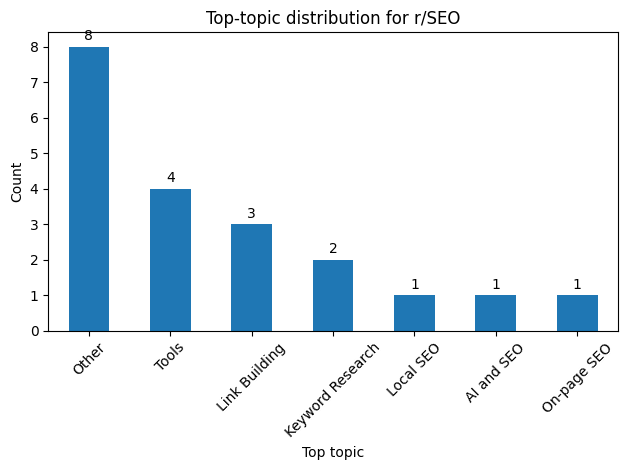


=== Other (top 1 examples) ===
1. [comment] score=1 conf=1.00
   Oh nice - win!!!
   ↗ https://www.reddit.com/r/SEO/comments/1ohwb8q/new_query_groups_in_search_console_insights/nlva4ox/

=== Tools (top 1 examples) ===
1. [thread] score=22 conf=0.95
   NEW! Query groups in Search Console Insights Monday, October 27, 2025 We are excited to announce [Query groups](https://support.google.com/webmasters/answer/16308503#query-groups), a powerful Search Console Insights feature that groups sim…
   ↗ https://www.reddit.com/r/SEO/comments/1ohwb8q/new_query_groups_in_search_console_insights/

=== Link Building (top 1 examples) ===
1. [thread] score=10 conf=0.95
   Under Massive Negative SEO Attack - 100+ Domains with Attacker's Telegram in Anchor Text My money keywords are tanking after a coordinated negative SEO attack. **The Attack:** * 100+ spam domains created since Oct 23 * Pattern: seo-anomaly…
   ↗ https://www.reddit.com/r/SEO/comments/1ojvqdx/under_massive_negative_seo_attack_100_domain

In [ ]:
# Let's show a graph with the topics and some examples for each topic

def plot_topic_distribution(frame: pd.DataFrame, title: str = "Topic distribution"):
    counts = frame["top_topic"].value_counts()
    ax = counts.plot(kind="bar", rot=45)
    ax.set_title(title)
    ax.set_xlabel("Top topic")
    ax.set_ylabel("Count")
    for i, v in enumerate(counts.values):
        ax.text(i, v + 0.1, str(v), ha="center", va="bottom", rotation=0)
    plt.tight_layout()
    plt.show()
    # Return the order used in the plot so we can print examples in the same order
    return list(counts.index)

def print_examples_by_topic(frame: pd.DataFrame, topics_in_order=None, n: int = 3, max_chars: int = 240, include_if_in_any_label: bool = False):
    """
    After plotting, print up to n examples per topic.
    By default, uses the 'top_topic' column. If include_if_in_any_label=True,
    also includes rows where the topic appears anywhere in 'topics' (multi-label).
    Sorts by per-topic confidence when available; otherwise falls back to Reddit 'score'.
    """
    if topics_in_order is None:
        topics_in_order = sorted(frame["top_topic"].dropna().unique().tolist())

    def _per_topic_score(row, topic):
        # Handle dict/string/None for topic_confidence robustly
        conf_map = row.get("topic_confidence")
        if isinstance(conf_map, str):
            try:
                conf_map = json.loads(conf_map)
            except Exception:
                conf_map = {}
        if isinstance(conf_map, dict):
            v = conf_map.get(topic)
            if isinstance(v, (int, float)):
                return float(v)
        # Fallback to Reddit score if no confidence is present
        sc = row.get("score")
        try:
            return float(sc) if sc is not None else -1.0
        except Exception:
            return -1.0

    for topic in topics_in_order:
        if include_if_in_any_label and "topics" in frame.columns:
            def _has_topic(xs):
                if isinstance(xs, str):
                    try:
                        xs = json.loads(xs)
                    except Exception:
                        # crude fallback for stringified lists
                        return topic in xs
                return isinstance(xs, (list, tuple)) and topic in xs
            subset = frame[frame["topics"].apply(_has_topic)].copy()
        else:
            subset = frame[frame["top_topic"] == topic].copy()

        if subset.empty:
            print(f"\n=== {topic}: no examples ===")
            continue

        subset["__topic_score__"] = subset.apply(lambda r: _per_topic_score(r, topic), axis=1)
        subset = subset.sort_values("__topic_score__", ascending=False)

        print(f"\n=== {topic} (top {min(n, len(subset))} examples) ===")
        for i, (_, row) in enumerate(subset.head(n).iterrows(), 1):
            txt = (row.get("text") or "").strip()
            txt = " ".join(txt.split())
            if len(txt) > max_chars:
                txt = txt[: max_chars - 1] + "…"

            link = row.get("permalink") or row.get("url") or ""
            origin = "thread" if row.get("type") == "thread" else "comment"

            # Show confidence for the *selected* top topic if we have it
            conf = None
            cmap = row.get("topic_confidence")
            if isinstance(cmap, str):
                try:
                    cmap = json.loads(cmap)
                except Exception:
                    cmap = {}
            if isinstance(cmap, dict):
                conf = cmap.get(row.get("top_topic"))
            conf_str = f"{float(conf):.2f}" if isinstance(conf, (int, float)) else "—"

            score = row.get("score", "NA")

            print(f"{i}. [{origin}] score={score} conf={conf_str}")
            print(f"   {txt}")
            if link:
                print(f"   ↗ {link}")

# Run the chart and the examples
ordered_topics = plot_topic_distribution(df, f"Top-topic distribution for r/{SUBREDDIT}")
print_examples_by_topic(df, topics_in_order=ordered_topics, n=number_of_examples_topics)


# 11. Extract Keywords

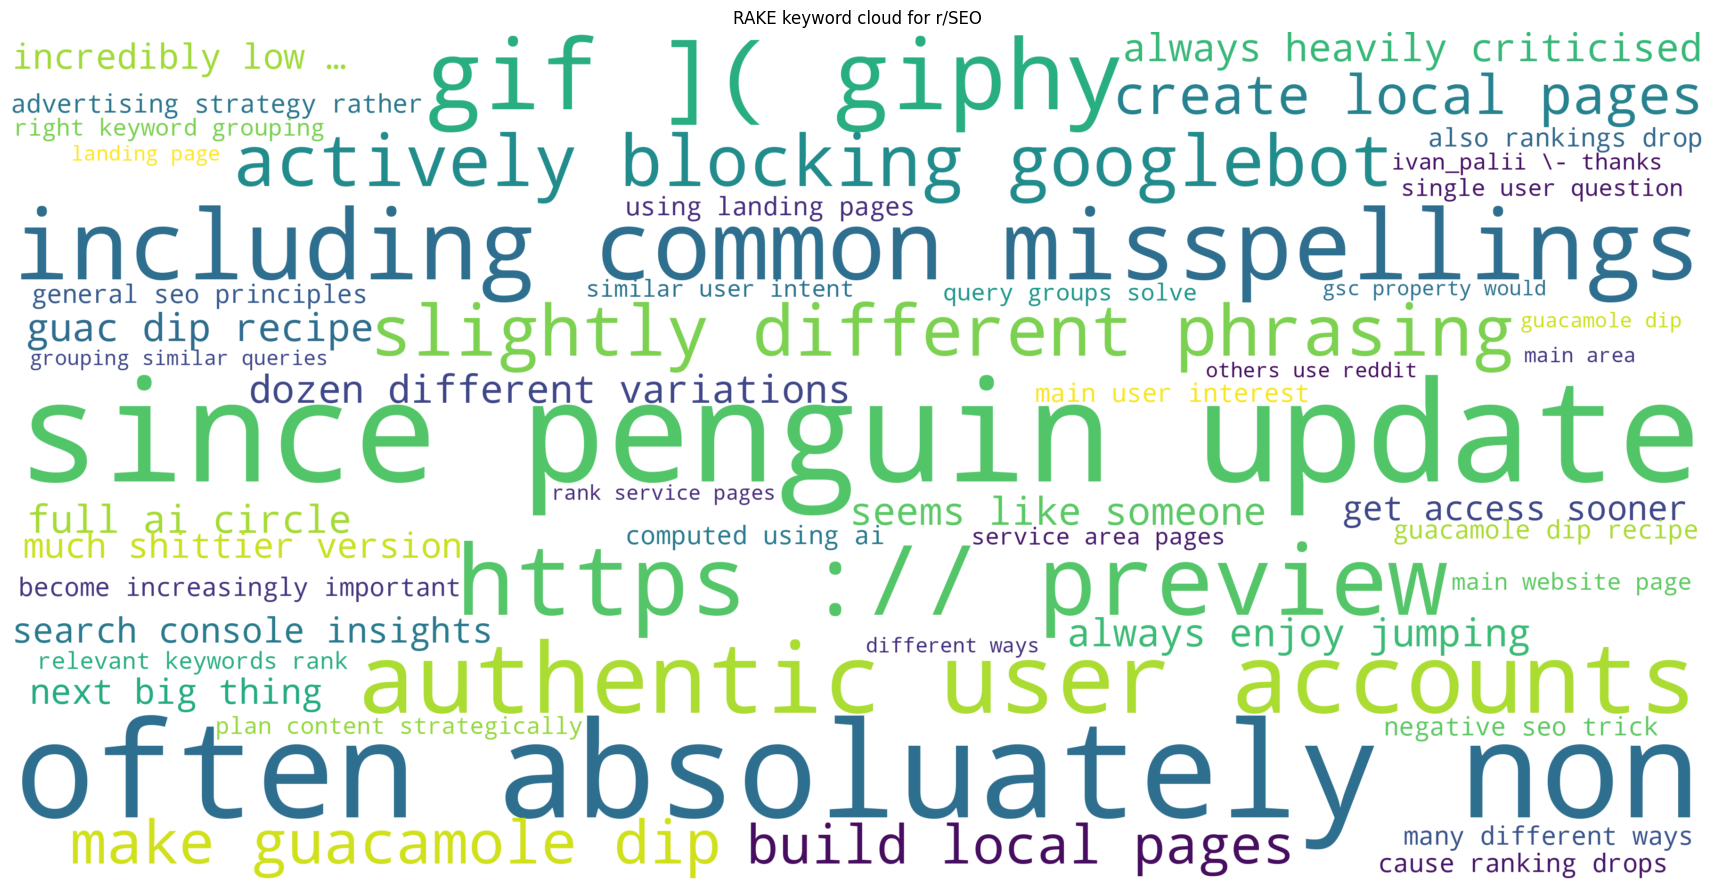

In [ ]:
def extract_rake_keywords(
    texts: List[str],
    top_n: int = 100,
    min_len: int = 1,
    max_len: int = 3,
    drop_urls: bool = True,
    dedupe: bool = True,
) -> List[Tuple[str, float]]:
    """
    Extract shorter, more 'wordcloud-friendly' phrases with RAKE.
    - min_len/max_len limit phrase length (shorter phrases pack better).
    - drop_urls removes URLs.
    - dedupe keeps the highest-scoring version of duplicate phrases (case-insensitive).
    Returns: list of (phrase, score) sorted by score desc, limited to top_n.
    """
    r = Rake(min_length=min_len, max_length=max_len)  # uses NLTK stopwords by default
    r.extract_keywords_from_text("\n".join([t for t in texts if t]))
    raw = r.get_ranked_phrases_with_scores()  # [(score, phrase), ...]

    cleaned: Dict[str, Tuple[float, str]] = {}
    for score, phrase in raw:
        p = " ".join((phrase or "").split())  # collapse whitespace
        if drop_urls:
            p = re.sub(r"(https?://\S+|www\.\S+)", "", p)
        p = p.strip(" .,:;!?()[]{}\"'`•–-").strip()
        if not p:
            continue
        k = p.casefold()
        if not dedupe:
            cleaned[p] = (float(score), p)
        else:
            # keep highest-scoring duplicate
            if k not in cleaned or float(score) > cleaned[k][0]:
                cleaned[k] = (float(score), p)

    # sort by score desc and take top_n
    top = sorted(cleaned.values(), key=lambda x: x[0], reverse=True)[:top_n]
    # convert to [(phrase, score)]
    return [(p, float(s)) for s, p in top]

def show_wordcloud_from_freq(
    freq_pairs: List[Tuple[str, float]] | Dict[str, float],
    title: str = "Word Cloud",
    *,
    max_words: int = 120,
    min_font_size: int = 16,
    max_font_size: int = 240,
    scale: int = 2,
    width: int = 1800,
    height: int = 900,
    margin: int = 1,
    prefer_horizontal: float = 0.95,
    relative_scaling: float = 0.3,
    repeat: bool = True,
    shrink_exponent: float = 0.7,
):
    """
    Make a denser/larger wordcloud:
    - Larger canvas (width/height) + scale=2 for crisp text
    - margin=1 and prefer_horizontal=0.95 reduces white space
    - repeat=True allows repeating terms to better fill gaps
    - relative_scaling lowers the size gap between frequent and rare phrases
    - shrink_exponent compresses score range so small words aren't microscopic
    """
    # Normalize input
    if isinstance(freq_pairs, dict):
        items = list(freq_pairs.items())
    else:
        items = list(freq_pairs)

    if not items:
        print("No data for word cloud.")
        return

    # Gently compress the score range to reduce size disparity (optional but helps)
    vals = np.array([s for _, s in items], dtype=float)
    vals = np.power(vals, shrink_exponent)
    # Rebuild as dict and cap to max_words
    items = sorted(zip([p for p, _ in items], vals), key=lambda x: x[1], reverse=True)[:max_words]
    freq_map = dict(items)

    wc = WordCloud(
        width=width,
        height=height,
        scale=scale,
        background_color="white",
        max_words=max_words,
        min_font_size=min_font_size,
        max_font_size=max_font_size,
        prefer_horizontal=prefer_horizontal,
        relative_scaling=relative_scaling,
        collocations=False,   # don't auto-join words into new collocations
        normalize_plurals=True,
        repeat=repeat,
        margin=margin,
    ).generate_from_frequencies(freq_map)

    plt.figure(figsize=(width/100, height/100))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- Use it ----
all_texts = df["text"].fillna("").tolist()

# Use your existing `keywords_to_extract` if defined; otherwise default to 120.
try:
    _top_n = int(keywords_to_extract)
except Exception:
    _top_n = 120

kw_pairs = extract_rake_keywords(
    all_texts,
    top_n=_top_n,
    min_len=keyword_min_length_of_words,
    max_len=keyword_max_length_of_words,
)

show_wordcloud_from_freq(
    kw_pairs,
    title=f"RAKE keyword cloud for r/{SUBREDDIT}",
    max_words=min(120, _top_n),  # cap visible items; more items => more tiny words
    min_font_size=16,
    max_font_size=260,
    scale=2,
    width=1800,
    height=900,
    margin=1,
    prefer_horizontal=0.95,
    relative_scaling=0.3,
    repeat=True,
    shrink_exponent=0.7,        # make small words larger relative to the biggest ones
)

# 12. Extract Entities

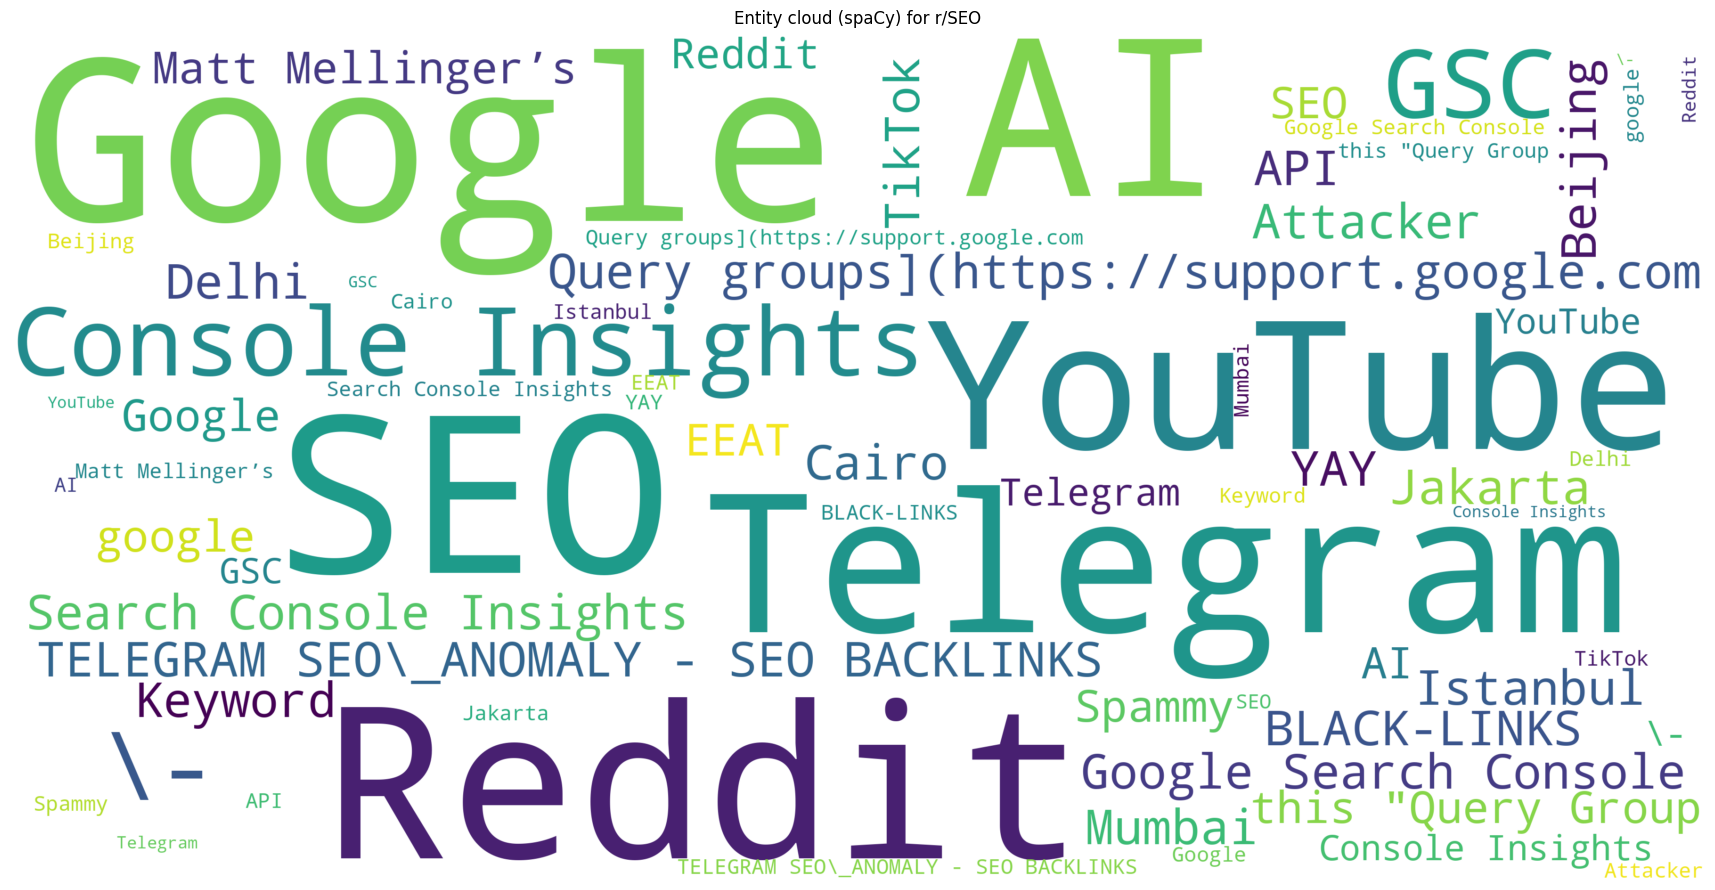

In [ ]:
# Keep common informative labels; skip numerics/dates
ALLOWED_NER_LABELS = {"PERSON","ORG","GPE","LOC","PRODUCT","EVENT","WORK_OF_ART","LAW","FAC","NORP"}

nlp = spacy.load("en_core_web_sm")
def extract_entities_spacy(texts: List[str], allowed_labels=ALLOWED_NER_LABELS) -> Counter:
    counts = Counter()
    for doc in nlp.pipe([t for t in texts if t], disable=["tagger","parser","lemmatizer"]):
        for ent in doc.ents:
            if ent.label_ in allowed_labels:
                token = ent.text.strip()
                if token:
                    counts[token] += 1
    return counts

ent_counts = extract_entities_spacy(all_texts)
show_wordcloud_from_freq(dict(ent_counts), title=f"Entity cloud (spaCy) for r/{SUBREDDIT}")

# 13. Multi‑dimensional slice: topic → sentiment + top keywords + top entities


Topic of interest: Tools — rows selected: 6 (top_topic or any-label)


Sentiment Analysis: 



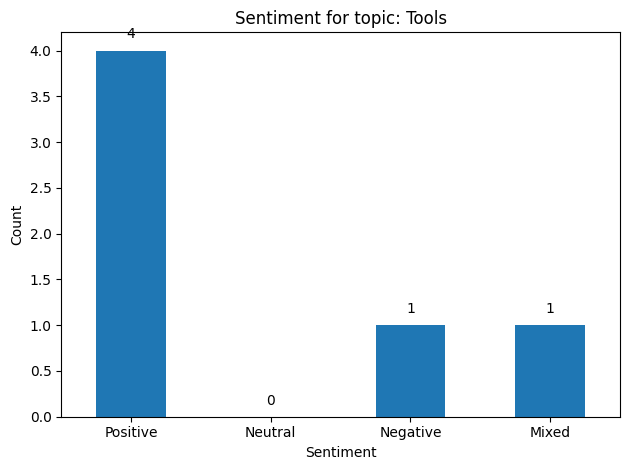



Keyword Extraction: 



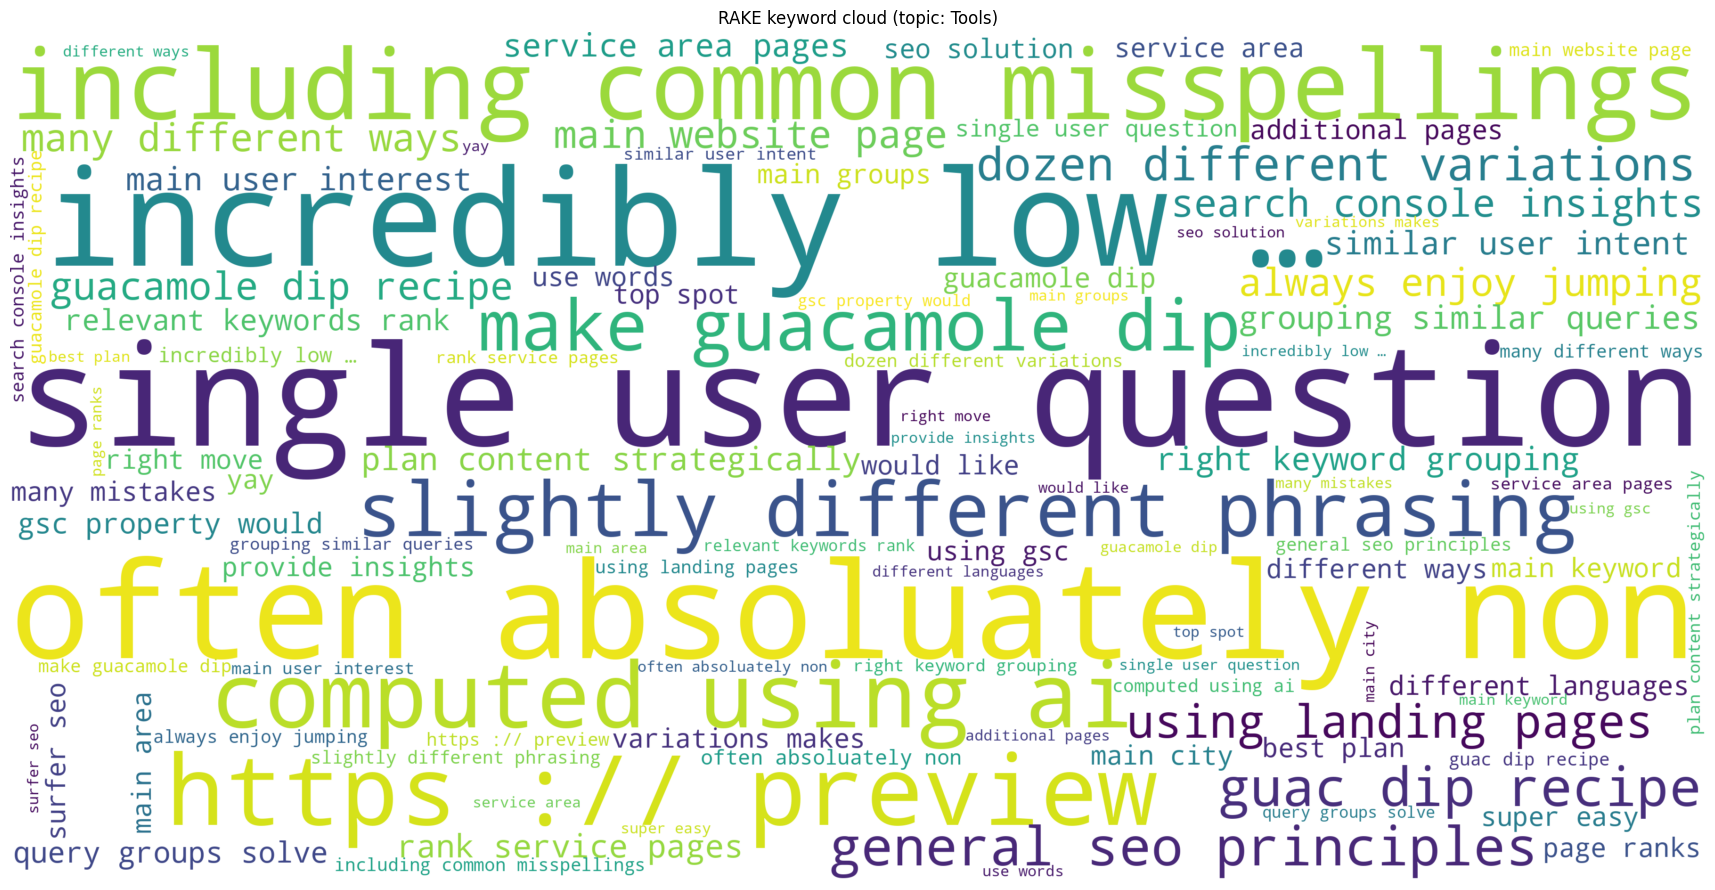




Entity Extraction: 



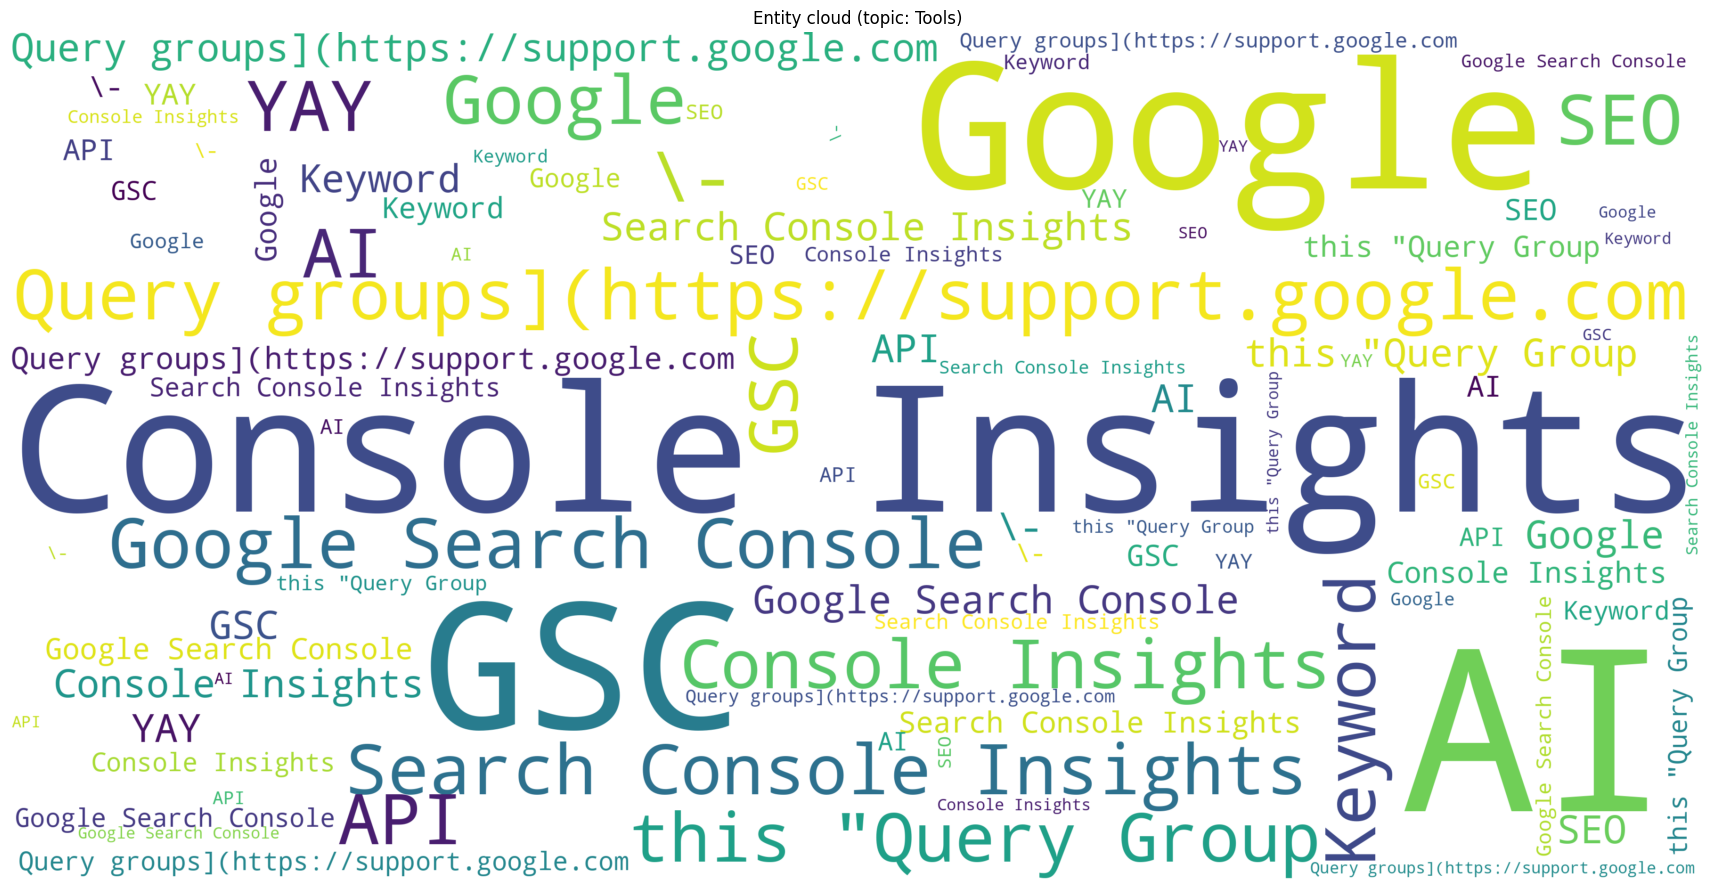

In [ ]:
# Show sentiment, keywords and entities for a specific topic (choose the topic in the step #4 config step)

INCLUDE_IF_IN_ANY_LABEL = True

def _norm(x):
    """Normalize text for safe comparisons (trim + casefold)."""
    try:
        return str(x).strip().casefold()
    except Exception:
        return ""

def _topics_contains(val, target_norm: str) -> bool:
    """
    Check whether 'val' (list/tuple/set or JSON/string) contains the target topic.
    Accepts Python lists, JSON-encoded lists, or plain strings.
    """
    if isinstance(val, (list, tuple, set)):
        return any(_norm(t) == target_norm for t in val)

    if isinstance(val, str):
        s = val.strip()
        # Try to parse JSON lists like '["A","B"]'
        if s.startswith(("[", "{")):
            try:
                decoded = json.loads(s)
                if isinstance(decoded, (list, tuple, set)):
                    return any(_norm(t) == target_norm for t in decoded)
            except Exception:
                pass
        # Fallback: exact/contains check on the string itself
        return _norm(s) == target_norm or (target_norm in _norm(s))

    return False

if "top_topic" not in df.columns:
    print("No topics available — run the topic classification step first.")
else:
    target = _norm(TOPIC_OF_INTEREST)

    # Build selection masks
    top_norm = df["top_topic"].astype(str).map(_norm)
    mask_top = top_norm == target

    mask_any = pd.Series(False, index=df.index)
    if "topics" in df.columns:
        mask_any = df["topics"].apply(lambda v: _topics_contains(v, target))

    # Combine according to your preference
    if INCLUDE_IF_IN_ANY_LABEL:
        mask = mask_top | mask_any
        selection_mode = "top_topic or any-label"
    else:
        mask = mask_top
        selection_mode = "top_topic only"

    df_slice = df[mask].copy()

    if df_slice.empty:
        print(f"No rows found for topic '{TOPIC_OF_INTEREST}' ({selection_mode}).")
    else:
        print(f"Topic of interest: {TOPIC_OF_INTEREST} — rows selected: {len(df_slice)} ({selection_mode})")

        # 1) Sentiment distribution within this topic slice
        print("\n")
        print("Sentiment Analysis: \n")
        plot_sentiment_distribution(df_slice, title=f"Sentiment for topic: {TOPIC_OF_INTEREST}")

        # 2) Keywords for this slice (RAKE)
        try:
            _k = int(keywords_to_extract)  # uses your existing variable if set elsewhere
        except Exception:
            _k = 150
        slice_kw_pairs = extract_rake_keywords(df_slice["text"].fillna("").tolist(), top_n=_k)
        print("\n")
        print("Keyword Extraction: \n")
        show_wordcloud_from_freq(dict(slice_kw_pairs), title=f"RAKE keyword cloud (topic: {TOPIC_OF_INTEREST})")

        print()

        # 3) Entities for this slice (spaCy NER)
        slice_ent_counts = extract_entities_spacy(df_slice["text"].fillna("").tolist())
        print("\n")
        print("Entity Extraction: \n")
        show_wordcloud_from_freq(dict(slice_ent_counts), title=f"Entity cloud (topic: {TOPIC_OF_INTEREST})")
